In [2]:
import tensorflow as tf 
import matplotlib.pyplot as plt 
import numpy as np 
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
A = np.random.normal(size=[100,2])
B = np.random.normal(size=[200,2], loc=1)
data = np.concatenate([A,B])

yA = np.array([1]*100 + [0]*200)
yB = np.ones(300)
y = np.concatenate([yA[:,np.newaxis], yB[:,np.newaxis]], axis=1)

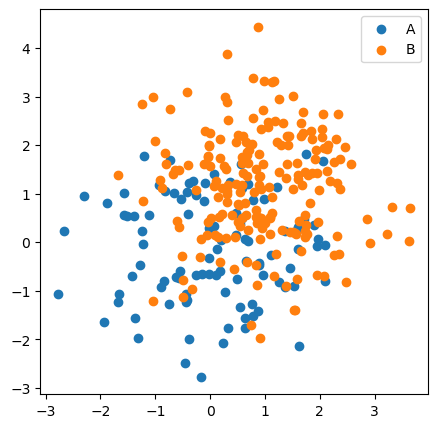

In [4]:
plt.figure(figsize=(5,5))
plt.scatter(A[:,0],A[:,1], label='A')
plt.scatter(B[:,0],B[:,1], label='B')
plt.legend()
plt.show()

In [5]:
class HMCModel(tf.keras.models.Model):
    def __init__(self):
        super(HMCModel, self).__init__()
        self.W1 = tf.keras.layers.Dense(10, activation='relu')
        self.W2 = tf.keras.layers.Dense(2, activation='sigmoid')
    def call(self, inputs):
        x = self.W1(inputs)
        outputs = self.W2(x)
        return outputs
    def postprocess(self, inputs):
        A = inputs[:,0]
        B = tf.reduce_max(inputs, axis=1)
        return tf.concat([A[:,tf.newaxis], B[:,tf.newaxis]], axis=1)

In [6]:
def loss_fn(y_true, y_pred):
    '''
    y_true    2 cols
    y_pred    2 cols, before postprocessing
    ''' 
    y_pred = tf.where(y_pred < 1e-20, 1e-20, y_pred)
    y_pred = tf.where(y_pred > 1-1e-20, 1-1e-20, y_pred)
    
    lossA = y_true[:,0] * tf.math.log(y_pred[:,0]) + (1-y_true[:,0]) * tf.math.log(1-y_pred[:,0])
    lossA = -tf.reduce_mean(lossA) 
    
    lossB_1 = y_true[:,1] * tf.math.log(tf.reduce_max(y_true * y_pred, axis=1))
    lossB_2 = (1-y_true[:,1]) * tf.math.log(1 - tf.reduce_max(y_pred, axis=1))
    lossB = -tf.reduce_mean(lossB_1 + lossB_2)
    
    return lossA + lossB 

In [7]:
model = HMCModel()
model.compile(
    loss=loss_fn,
    optimizer='adam'
)

idx = np.random.permutation(300)
data = data[idx]
y = y[idx]

train_x, valid_x = data[:250], data[250:]
train_y, valid_y = y[:250], y[250:]

model.fit(train_x, train_y, epochs=200, validation_data=(valid_x, valid_y))

Epoch 1/200
8/8 [==============================] - 1s 38ms/step - loss: 1.9767 - val_loss: 1.8007
Epoch 2/200
8/8 [==============================] - 0s 16ms/step - loss: 1.9231 - val_loss: 1.7615
Epoch 3/200
8/8 [==============================] - 0s 6ms/step - loss: 1.8717 - val_loss: 1.7248
Epoch 4/200
8/8 [==============================] - 0s 6ms/step - loss: 1.8206 - val_loss: 1.6899
Epoch 5/200
8/8 [==============================] - 0s 7ms/step - loss: 1.7771 - val_loss: 1.6554
Epoch 6/200
8/8 [==============================] - 0s 7ms/step - loss: 1.7319 - val_loss: 1.6227
Epoch 7/200
8/8 [==============================] - 0s 9ms/step - loss: 1.6893 - val_loss: 1.5918
Epoch 8/200
8/8 [==============================] - 0s 7ms/step - loss: 1.6477 - val_loss: 1.5616
Epoch 9/200
8/8 [==============================] - 0s 6ms/step - loss: 1.6091 - val_loss: 1.5324
Epoch 10/200
8/8 [==============================] - 0s 6ms/step - loss: 1.5713 - val_loss: 1.5037
Epoch 11/200
8/8 [=========

In [8]:
def get_area(x1, y1, x2, y2):
    '''
    x1 < x2, the inequality should be strict
    '''
    return (y1 + y2) * (x2 - x1) / 2

def get_score(model, x, y):
    pred = model(x)
    pred = model.postprocess(pred)
    
    precision_list = [0]
    recall_list = [1]
    for threshold in np.arange(0.01, 1, 0.01):
        pred_int = tf.cast(pred >= threshold, tf.int16)
        tp = pred_int * y 
        fp = pred_int * (1-y)
        fn = (1-pred_int) * y
        
        tp = tf.reduce_sum(tp)
        fp = tf.reduce_sum(fp)
        fn = tf.reduce_sum(fn)
        
        precision = tp / (tp+fp)
        recall = tp / (tp+fn)
        
        if not (np.isnan(precision) or np.isnan(recall)):
            precision_list.append(precision)
            recall_list.append(recall)
        
    idx = np.argsort(precision_list)
    precision_np = np.array(precision_list)
    recall_np = np.array(recall_list)
    
    precision_np = precision_np[idx]
    recall_np = recall_np[idx]
    
    area = 0 
    for i in range(len(precision_np)-1):
        area += get_area(precision_np[i], recall_np[i], precision_np[i+1], recall_np[i+1])
    
    return area
    

In [9]:
print("Training area under precision recall curve: {}".format(get_score(model, train_x, train_y)))
print("Validation area under precision recall curve: {}".format(get_score(model, valid_x, valid_y)))

Training area under precision recall curve: 0.9830165436889526
Validation area under precision recall curve: 0.9751449476858127


In [10]:
# traditional loss function for comparison
def loss_fn_traditional(y_true, y_pred):
    '''
    y_true    2 cols
    y_pred    2 cols, before postprocessing
    ''' 
    y_pred = tf.where(y_pred < 1e-20, 1e-20, y_pred)
    y_pred = tf.where(y_pred > 1-1e-20, 1-1e-20, y_pred)
    
    lossA = y_true[:,0] * tf.math.log(y_pred[:,0]) + (1-y_true[:,0]) * tf.math.log(1-y_pred[:,0])
    lossA = -tf.reduce_mean(lossA) 
    
    lossB_1 = y_true[:,1] * tf.math.log(tf.reduce_max(y_pred, axis=1)) # y_true removed, comparing with the above loss function
    lossB_2 = (1-y_true[:,1]) * tf.math.log(1 - tf.reduce_max(y_pred, axis=1))
    lossB = -tf.reduce_mean(lossB_1 + lossB_2)
    
    return lossA + lossB 

model = HMCModel()
model.compile(
    loss=loss_fn_traditional,
    optimizer='adam'
)

idx = np.random.permutation(300)
data = data[idx]
y = y[idx]

train_x, valid_x = data[:250], data[250:]
train_y, valid_y = y[:250], y[250:]

model.fit(train_x, train_y, epochs=150, validation_data=(valid_x, valid_y))

Epoch 1/150
8/8 [==============================] - 1s 27ms/step - loss: 1.2678 - val_loss: 1.2585
Epoch 2/150
8/8 [==============================] - 0s 6ms/step - loss: 1.2441 - val_loss: 1.2350
Epoch 3/150
8/8 [==============================] - 0s 6ms/step - loss: 1.2210 - val_loss: 1.2117
Epoch 4/150
8/8 [==============================] - 0s 5ms/step - loss: 1.1987 - val_loss: 1.1886
Epoch 5/150
8/8 [==============================] - 0s 6ms/step - loss: 1.1764 - val_loss: 1.1656
Epoch 6/150
8/8 [==============================] - 0s 7ms/step - loss: 1.1536 - val_loss: 1.1432
Epoch 7/150
8/8 [==============================] - 0s 8ms/step - loss: 1.1325 - val_loss: 1.1203
Epoch 8/150
8/8 [==============================] - 0s 6ms/step - loss: 1.1112 - val_loss: 1.0976
Epoch 9/150
8/8 [==============================] - 0s 6ms/step - loss: 1.0897 - val_loss: 1.0756
Epoch 10/150
8/8 [==============================] - 0s 6ms/step - loss: 1.0689 - val_loss: 1.0538
Epoch 11/150
8/8 [==========

In [11]:
print("Training area under precision and recall curve: {}".format(get_score(model, train_x, train_y)))
print("Validation area under precision and recall curve: {}".format(get_score(model, valid_x, valid_y)))

Training average precision and recall: 0.9819780510261467
Validation average precision and recall: 0.9859335266808511
